# AdaGrad

## Definition: AdaGrad (Adaptive Gradient Algorithm)

AdaGrad (Duchi et al., 2011) adapts the learning rate **per parameter** using
the history of squared gradients. Directions with consistently large gradients
(steep or unstable regions prone to overshooting) get smaller steps, while
directions with small or rare gradients get larger ones. The squared-gradient
history acts as a heuristic measure of how “safe” or “risky” each direction is.

Given the gradient:
$$
g_t = \nabla_\theta L(\theta_t),
$$

AdaGrad accumulates squared gradients:
$$
s_{t+1} = s_{t} + g_{t}^2,
$$

and updates parameters using:
$$
\theta_{t+1}
= \theta_{t}
- \eta\, \frac{g_{t}}{\sqrt{s_{t+1}} + \varepsilon}.
$$
where the operations here are ocmponentwise.

**Note:** Since $s_{t}$ grows monotonically, the effective learning rate

$1/\sqrt{s_{t}}$ shrinks to zero, causing AdaGrad to stall. RMSProp and Adam
fix this by using an exponential moving average instead of an unbounded sum.

## Code: AdaGrad

In [224]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from model.mlp import MLP### Training loop

In [225]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps=1e-10, weight_decay=0.0):
        defaults = {
            "lr": lr,
            "eps": eps,
            "weight_decay": weight_decay,
        }
        # Parent class creates param_groups and self.state
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single AdaGrad update step."""
        for group in self.param_groups:
            lr = group["lr"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad

                # Optional L2 weight decay: grad <- grad + λ θ
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)

                # Initialize state for accumulator parameter s_0 = 0
                state = self.state[p]
                if "accumulator" not in state:
                    state["accumulator"] = torch.zeros_like(p)

                s = state["accumulator"]

                # s_{t+1} = s_t + g_t^2 (elementwise square)
                s.add_(grad.pow(2))

                # Denominator: sqrt(s_{t+1}) + eps
                denom = s.sqrt().add_(eps)

                # Parameter update:
                # θ <- θ - lr * g / denom
                p.addcdiv_(grad, denom, value=-lr)

### Data

In [226]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

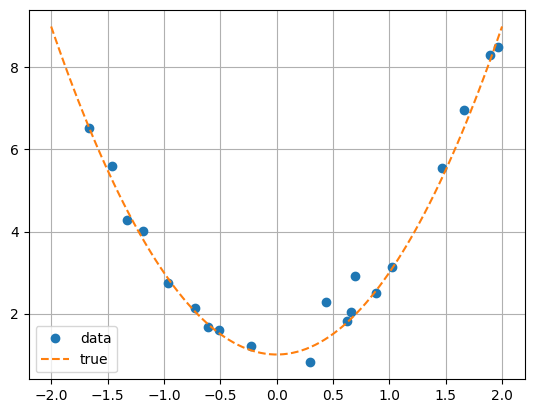

In [227]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [228]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [229]:
lr = 0.001
momentum = 0.9
dampening = 0.0
weight_decay= 0.001
nesterov = False

loss_fn = nn.MSELoss()  

### pytorch

In [230]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.ReLU())
opt = torch.optim.Adagrad(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)

Epoch 1/150, Loss: 19.4494
Epoch 2/150, Loss: 13.9104
Epoch 3/150, Loss: 9.3725
Epoch 4/150, Loss: 5.4166
Epoch 5/150, Loss: 2.9473
Epoch 6/150, Loss: 2.0532
Epoch 7/150, Loss: 1.8020
Epoch 8/150, Loss: 1.6543
Epoch 9/150, Loss: 1.5353
Epoch 10/150, Loss: 1.4304
Epoch 11/150, Loss: 1.3321
Epoch 12/150, Loss: 1.2393
Epoch 13/150, Loss: 1.1519
Epoch 14/150, Loss: 1.0692
Epoch 15/150, Loss: 0.9913
Epoch 16/150, Loss: 0.9182
Epoch 17/150, Loss: 0.8491
Epoch 18/150, Loss: 0.7842
Epoch 19/150, Loss: 0.7231
Epoch 20/150, Loss: 0.6661
Epoch 21/150, Loss: 0.6130
Epoch 22/150, Loss: 0.5635
Epoch 23/150, Loss: 0.5183
Epoch 24/150, Loss: 0.4764
Epoch 25/150, Loss: 0.4376
Epoch 26/150, Loss: 0.4022
Epoch 27/150, Loss: 0.3692
Epoch 28/150, Loss: 0.3386
Epoch 29/150, Loss: 0.3115
Epoch 30/150, Loss: 0.2873
Epoch 31/150, Loss: 0.2657
Epoch 32/150, Loss: 0.2462
Epoch 33/150, Loss: 0.2286
Epoch 34/150, Loss: 0.2129
Epoch 35/150, Loss: 0.1995
Epoch 36/150, Loss: 0.1882
Epoch 37/150, Loss: 0.1785
Epoch 38

### Custom

Epoch 1/150, Loss: 19.4494
Epoch 2/150, Loss: 13.9104
Epoch 3/150, Loss: 9.3725
Epoch 4/150, Loss: 5.4166
Epoch 5/150, Loss: 2.9473
Epoch 6/150, Loss: 2.0532
Epoch 7/150, Loss: 1.8020
Epoch 8/150, Loss: 1.6543
Epoch 9/150, Loss: 1.5353
Epoch 10/150, Loss: 1.4304
Epoch 11/150, Loss: 1.3321
Epoch 12/150, Loss: 1.2393
Epoch 13/150, Loss: 1.1519
Epoch 14/150, Loss: 1.0692
Epoch 15/150, Loss: 0.9913
Epoch 16/150, Loss: 0.9182
Epoch 17/150, Loss: 0.8491
Epoch 18/150, Loss: 0.7842
Epoch 19/150, Loss: 0.7231
Epoch 20/150, Loss: 0.6661
Epoch 21/150, Loss: 0.6130
Epoch 22/150, Loss: 0.5635
Epoch 23/150, Loss: 0.5183
Epoch 24/150, Loss: 0.4764
Epoch 25/150, Loss: 0.4376
Epoch 26/150, Loss: 0.4022
Epoch 27/150, Loss: 0.3692
Epoch 28/150, Loss: 0.3386
Epoch 29/150, Loss: 0.3115
Epoch 30/150, Loss: 0.2873
Epoch 31/150, Loss: 0.2657
Epoch 32/150, Loss: 0.2462
Epoch 33/150, Loss: 0.2286
Epoch 34/150, Loss: 0.2129
Epoch 35/150, Loss: 0.1995
Epoch 36/150, Loss: 0.1882
Epoch 37/150, Loss: 0.1785
Epoch 38

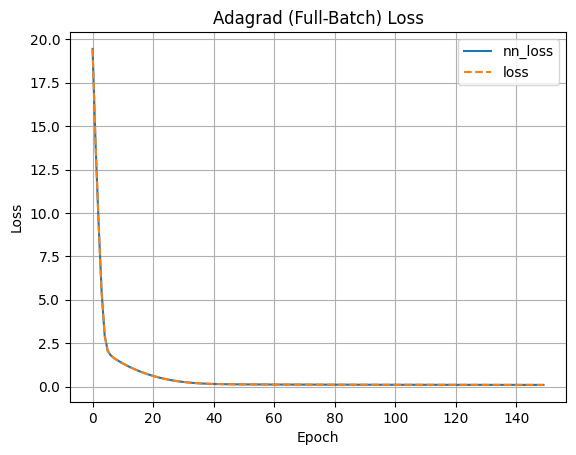

In [231]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.ReLU())
opt = Adagrad(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)
compare_losses(loss,nn_loss,"Adagrad (Full-Batch) Loss")

# Evaluation

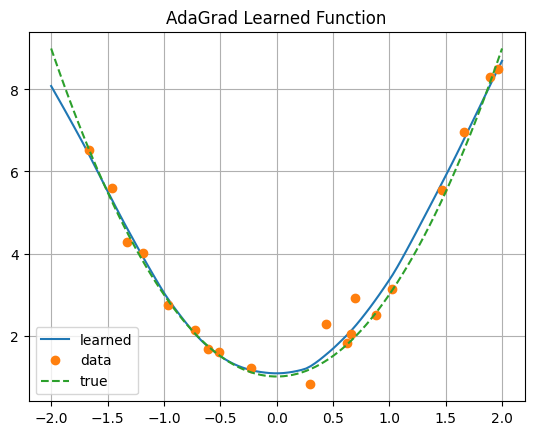

In [232]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("AdaGrad Learned Function")
plt.legend()
plt.grid()
plt.show()